In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torchvision.transforms.functional as F
from torchvision.models.vision_transformer import vit_b_16
from PIL import Image
import cv2
import random
import os

In [3]:
class EdgeEnhancementTransform:
    def __call__(self, img):
        # img = np.array(F.to_grayscale(img))  # Convert to grayscale
        img = np.array(img)
        img = cv2.GaussianBlur(img, (3, 3), 0)  # Reduce noise
        edges = cv2.Laplacian(img, cv2.CV_64F)  # Edge detection
        edges = np.clip((edges - edges.min()) / (edges.max() - edges.min()) * 255, 0, 255).astype(np.uint8)
        return Image.fromarray(edges)
        # return F.to_tensor()

# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([EdgeEnhancementTransform()], p=0.5),  # Apply edge emphasis randomly
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjusted normalization
])
# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [4]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# data loaders
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Number of training samples: 5400
Number of testing samples: 1351


In [5]:
# Load the ViT model
model = vit_b_16(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
num_classes = len(class_names)
model.heads.head = nn.Linear(model.hidden_dim, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.head.parameters(), lr=0.001)

c:\Users\danym\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danym\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [6]:
# Training loop
epochs = 10
print("Training started...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...
Epoch 1/10, Loss: 1.0059
Epoch 2/10, Loss: 0.6154
Epoch 3/10, Loss: 0.5343
Epoch 4/10, Loss: 0.4853
Epoch 5/10, Loss: 0.4633
Epoch 6/10, Loss: 0.4450
Epoch 7/10, Loss: 0.4194
Epoch 8/10, Loss: 0.3969
Epoch 9/10, Loss: 0.3854
Epoch 10/10, Loss: 0.3819
Training complete.


In [7]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score
fscore = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'vit_model2.pth')
print("Model saved.")

Testing Accuracy: 82.61%
F1-Score: 0.8232
Model saved.


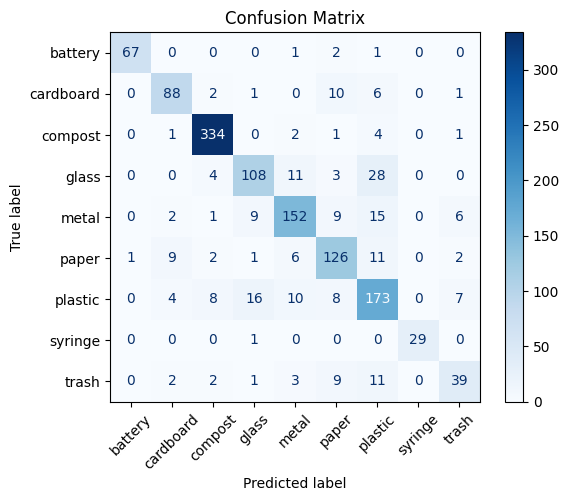

              precision    recall  f1-score   support

     battery       0.99      0.94      0.96        71
   cardboard       0.83      0.81      0.82       108
     compost       0.95      0.97      0.96       343
       glass       0.79      0.70      0.74       154
       metal       0.82      0.78      0.80       194
       paper       0.75      0.80      0.77       158
     plastic       0.69      0.77      0.73       226
     syringe       1.00      0.97      0.98        30
       trash       0.70      0.58      0.63        67

    accuracy                           0.83      1351
   macro avg       0.83      0.81      0.82      1351
weighted avg       0.83      0.83      0.83      1351



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

class_names = ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Print detailed classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))